# Introduction to T-Matrix

This notebook investigates the use of the pymatrix T-matrix code for simulating polarimetric observables in rain.

The code was originally developed by Barber and Yeh (1991); this implementation uses code developed by M. I. Mishchenko and L. D. Travis from NASA Goddard Institute for Space Studies as implemented in python by Jussi Leionen from NASA Jet Propulsion Laboratory.

## Installing pytmatrix

The webpage for pytmatrix is hosted on [github](https://www.google.com)


The code may not install using the typical `pip` install, but you can first try
```bash
$ sudo pip install pytmatrix
```

If that fails, you can install the source yourself
```bash
$ git clone https://github.com/jleinonen/pytmatrix.git
$ cd pytmatrix
$ python setup.py install
```

It's always a good idea to test simulation code after installation, and this can be done easily.

In [150]:
from pytmatrix.test import test_tmatrix
test_tmatrix.run_tests()

test_adaptive_orient (pytmatrix.test.test_tmatrix.TMatrixTests)
Test an adaptive orientation averaging case ... ok
test_against_mie (pytmatrix.test.test_tmatrix.TMatrixTests)
Test scattering parameters against Mie results ... ok
test_asymmetry (pytmatrix.test.test_tmatrix.TMatrixTests)
Test calculation of the asymmetry parameter ... ok
test_fixed_orient (pytmatrix.test.test_tmatrix.TMatrixTests)
Test a fixed-point orientation averaging case ... ok
test_integrated_x_sca (pytmatrix.test.test_tmatrix.TMatrixTests)
Test Rayleigh scattering cross section integrated over sizes. ... ok
test_optical_theorem (pytmatrix.test.test_tmatrix.TMatrixTests)
Optical theorem: test that for a lossless particle, Csca=Cext ... ok
test_psd (pytmatrix.test.test_tmatrix.TMatrixTests)
Test a case that integrates over a particle size distribution ... ok
test_radar (pytmatrix.test.test_tmatrix.TMatrixTests)
Test that the radar properties are computed correctly ... ok
test_rayleigh (pytmatrix.test.test_tmatrix.TM

The test will report success if the accuracy of the simulations is acceptable.

## What is T-matrix?

T-matrix, as implemented here, is a computationally efficient method to numerically determine the scattering and absorption properties of elliptically shaped particles (with a given axis ratio defined as D_minor/D_major), with a given refractive index, mean canting angle, and standard deviation of canting angle.

The code has been shown to perform well compared with more advanced scattering codes for axis rations > 0.2, which fortunately covers the natural variations in axis ratios for raindrops.

## How do we model droplet shape?

Due to aerodynamic forces, rain droplets take on an oblate shape as they exceed ~0.7 mm in equivalent volume diameter (defined as the equivalent diameter a spherical droplet would have if it had the same volume as a non-spherical droplet).  Turbulence and the internal dynamics of droplets also cause oscillations in droplets, and droplets tend to break up at sizes greater than 5-6 mm.  Droplets up to nearly 10 mm have been observed, typically stabilized by ice cores (i.e. melting hail).
![alt text](http://upload.wikimedia.org/wikipedia/commons/thumb/5/57/Raindrops_sizes.svg/500px-Raindrops_sizes.svg.png "Raindrop_sizes")

Laboratory measurements, aircraft probe data, and surface video disdrometer data have been used to quantify the droplet axis ratio as a function of size.  Work using the 2-D Video Disdrometer (2DVD) has provided the highest quality data to date of the shapes of raindrops.

The 2DVD uses two orthogonal line scan cameras to image drops that fall into its 10 x 10 cm viewing area.
<img src="http://www.iac.ethz.ch/en/groups/richner/cd/doc/optisch/2d-video-distrometer.jpg" alt="2DVD" style="width: 400px;"/>

An example image from the 2DVD is shown here:
<img src="http://earthobservatory.nasa.gov/blogs/fromthefield/files/2013/05/IFloodS_2dvdsn37_468.jpg" alt="2DVD example" style="width: 600px;"/>

##Emprical models of droplet shape
Numerous studies have developed models of raindrop shape as a function of size.  Significant uncertainty exists in the larger droplet sizes due to measurement uncertainties as well as statistical sampling error.  Also, the results of laboratory and field studies disagree, it is thought that this may be due to turbulent effects on the droplet shape as well as the need for droplets to relax to their natural shapes (which requires a significant fall distance for artifical drops).

A recent study of droplet shape using artifical drops was led by Merhala Thurai from Colorado State University:

Thurai, M., G.J. Huang, V.N. Bringi, W. L. Randeu and M. Schönhuber, 2007: Drop Shapes, Model Comparisons, and Calculations of Polarimetric Radar Parameters in Rain, *J. Atmos. Ocean. Tech.*, **24**, 6, 1019-1032. (<a href="http://journals.ametsoc.org/doi/abs/10.1175/JTECH2051.1">link</a>)

Images of droplets were composited to form statistical distributions of droplet shape:
<img src="http://journals.ametsoc.org/na101/home/literatum/publisher/ams/journals/content/atot/2007/15200426-24.6/jtech2051.1/production/images/medium/i1520-0426-24-6-1019-f01.jpg" alt="2DVD example";/>

From their results, the following expressions can be used to calculate the axis ratios depending on equivalent diameter $D_{eq}$:

$$D_{eq} < 0.7 \text{ mm :}$$
$$a/b = 1.0$$

$$0.7 \le D_{eq} < 1.5 \text{ mm :}$$
$$a/b = 1.173 - 0.5165D_{eq} + 0.4698D_{eq}^{2} - 0.1317D_{eq}^{3} - 8.5\times 10^{-3}D_{eq}^{4} $$

$$D_{eq} \ge 1.5 \text{ mm :}$$
$$a/b = 1.065 - 6.25\times 10^{-2}D_{eq} - 3.99\times 10^{3}D_{eq}^2 + 7.66\times 10^{-4}D_{eq}^{3} - 4.095\times 10^{-5}D_{eq}^4$$ 

Using the droplet size and shape model, and assumptions about droplet canting and its distribution, we can use T-matrix to calculate the polarimetric observables.

Let's get started!

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from scipy import constants
from pytmatrix.tmatrix import Scatterer
from pytmatrix import psd, orientation, radar, tmatrix_aux, refractive

We define a scatterer class to define a particle.  Here we do a single particle.

In [152]:
scatterer = Scatterer(radius=2.0, wavelength=5.3, m=complex(1.5, 0.5), axis_ratio=1.0/0.6)

Let's run the model and get the amplitude scattering matrix.

In [153]:
scatterer.get_S()

array([[ -8.59466680e-02 -1.90234930e-01j,
          3.35609035e-24 -2.59281464e-24j],
       [ -3.35537274e-24 +2.59409321e-24j,
         -3.70011592e-02 +2.00078313e-01j]])

Get the scattering and phase matrix at once.

In [154]:
scatterer.get_SZ()

(array([[ -8.59466680e-02 -1.90234930e-01j,
           3.35609035e-24 -2.59281464e-24j],
        [ -3.35537274e-24 +2.59409321e-24j,
          -3.70011592e-02 +2.00078313e-01j]]),
 array([[  4.24882877e-02,   1.08787076e-03,  -8.47973602e-25,
           2.85936533e-25],
        [  1.08787076e-03,   4.24882877e-02,   4.38375342e-25,
           1.43664225e-24],
        [  8.48049246e-25,  -4.37841178e-25,  -3.48817575e-02,
           2.42349772e-02],
        [  2.85719020e-25,   1.43680651e-24,  -2.42349772e-02,
          -3.48817575e-02]]))

Demonstrate the use of the orientation pdf.

In [155]:
scatterer = Scatterer(radius=2.0, wavelength=6.5, m=complex(1.5,0.5), axis_ratio=1.0/0.6)
scatterer.or_pdf = orientation.gaussian_pdf(std=20.0)
scatterer.orient = orientation.orient_averaged_adaptive
scatterer.get_S()


array([[  6.49005717e-02 -2.42488000e-01j,
         -6.13348032e-16 -4.11094414e-15j],
       [ -1.50045335e-14 -1.63765221e-15j,
         -9.54176591e-02 +2.84758322e-01j]])

Demonstrate the use of the Gamma PSD for a size distribution of particles.

In [30]:
scatterer = Scatterer(wavelength=6.5, m=complex(1.5,0.5), axis_ratio=1.0/0.6)
scatterer.psd_integrator = psd.PSDIntegrator()
scatterer.psd = psd.GammaPSD(D0=1.0, Nw=1e3, mu=4)
scatterer.psd_integrator.D_max = 10.0
scatterer.psd_integrator.init_scatter_table(scatterer)
scatterer.get_Z()


array([[  7.20539942e-02,  -1.54020511e-02,  -9.96254906e-25,
          8.34272669e-26],
       [ -1.54020511e-02,   7.20539942e-02,   1.23283189e-25,
          1.40052500e-25],
       [  9.96257383e-25,  -1.23295004e-25,  -6.89738802e-02,
          1.38873117e-02],
       [  8.34164328e-26,   1.40052281e-25,  -1.38873117e-02,
         -6.89738802e-02]])

Now, use the radar module to calculate the radar parameters for a known problem.  1000 1-mm drops per meter cubed = 30 dBZ.  Assume spherical drops.

In [2]:
#test for known quantity
bins=[.99,1.01]
bins_mid=[1.0]
dsd=[1000./.02] #mm**-1 m**-3

#Calculate rayleigh reflectivity
#sum N(D)dD*D**6
ray_Z=np.sum(np.multiply(dsd*np.diff(bins),np.power(bins_mid,6.)))


scatterer = Scatterer(wavelength=tmatrix_aux.wl_C, m=refractive.m_w_10C[tmatrix_aux.wl_C], axis_ratio=1.0/0.6)
#scatterer = Scatterer(wavelength=6.5, m=complex(1.5,0.5), axis_ratio=1.0/0.6)
scatterer.psd_integrator = psd.PSDIntegrator()
scatterer.psd_integrator.D_max = 10.0
scatterer.psd_integrator.geometries = (tmatrix_aux.geom_horiz_back, tmatrix_aux.geom_horiz_forw)
scatterer.psd_integrator.init_scatter_table(scatterer)
scatterer.orient = orientation.orient_averaged_fixed
scatterer.psd = psd.BinnedPSD(bins,dsd)
scatterer.get_Z()
print "Rayleigh reflectivity (Z_e): "+str(ray_Z)
print "Rayleigh reflectivity (dBZ_e): "+str(10.*np.log10(ray_Z))
print "Horizontal reflectivity (Z_e): "+str(radar.refl(scatterer))
#convert to log units
print "Horizontal reflectivity factor (dBZ_e): "+str(10.*np.log10(radar.refl(scatterer)))
print "Differential reflectivity (dB): "+str(10.*np.log10(radar.Zdr(scatterer)))

print "Linear depolarization ratio (dB): "+str(10.*np.log10(radar.ldr(scatterer)))
print "Rho_hv (unitless): "+str(radar.rho_hv(scatterer))
#need to set this for Kdp calculation to set geometry
scatterer.set_geometry(tmatrix_aux.geom_horiz_forw)
print "Specific differential phase (deg/km): "+str(radar.Kdp(scatterer))
#convert into traditional sense; add 180.
print "Backscatter differential phase (deg/km): "+str(180.+np.rad2deg(radar.delta_hv(scatterer)))

print "Specific attenuation (dBZ/km): "+str(radar.Ai(scatterer))


Rayleigh reflectivity (Z_e): 1000.0
Rayleigh reflectivity (dBZ_e): 30.0
Horizontal reflectivity (Z_e): 1536.75816468
Horizontal reflectivity factor (dBZ_e): 31.8660552917
Differential reflectivity (dB): 5.01635382292
Linear depolarization ratio (dB): nan
Rho_hv (unitless): 0.999999999911
Specific differential phase (deg/km): 2.79463718423
Backscatter differential phase (deg/km): 0.478496437841
Specific attenuation (dBZ/km): 0.0216643882476


/net/san-a1-ib/data/keeling/a/snesbitt/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:27: RuntimeWarning: invalid value encountered in log10


Now, use an observed particle size distribution and the Thurai drop shape model.  You can try turning on the canting angle distribution.  Note that orientation averaging is turned on to average the signal across incidence angles.

In [3]:
### DSD obs from a Parsivel2 disdrometer in Finland during LPVEX (rain case)  units:mm**-1 m**-3
dsd=np.array([   0.    ,    0.    ,   77.6576,  254.0345,  441.4923,  393.8862,
        534.6022,  493.5842,  258.9568,  155.7294,  115.5232,   57.1851,
         38.8442,   30.7712,   29.0522,   29.5414,   35.4124,   12.3951,
          3.5907,    4.2942,    1.0822,    0.    ,    0.    ,    0.    ,
          0.    ,    0.    ,    0.    ,    0.    ,    0.    ,    0.    ,
          0.    ,    0.    ])
#bins in mm
bins=np.array([  0.062,   0.187,   0.312,   0.437,   0.562,   0.687,   0.812,
         0.937,   1.062,   1.187,   1.312,   1.625,   1.875,   2.125,
         2.375,   2.625,   3.25 ,   3.75 ,   4.25 ,   4.75 ,   5.25 ,
         6.5  ,   7.5  ,   8.5  ,   9.5  ,  10.5  ,  13.   ,  15.   ,
        17.   ,  19.   ,  21.   ,  24.5  ,  27.5  ])
bins_mid=np.array([  0.1245,   0.2495,   0.3745,   0.4995,   0.6245,   0.7495,
         0.8745,   0.9995,   1.1245,   1.2495,   1.5   ,   1.75  ,
         2.    ,   2.25  ,   2.5   ,   3.    ,   3.5   ,   4.    ,
         4.5   ,   5.    ,   6.    ,   7.    ,   8.    ,   9.    ,
        10.    ,  12.    ,  14.    ,  16.    ,  18.    ,  20.    ,
        23.    ,  26.    ])
bins_width=np.array([ 0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ,  2.2,
        2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,  3.8,  4. ,  4.2,  4.4,
        4.6,  4.8,  5. ,  5.2,  5.4,  5.6,  5.8,  6. ,  6.2,  6.4,  6.6,
        6.8,  7. ,  7.2,  7.4,  7.6,  7.8,  8. ,  8.2])

#convert to m**-3 mm**-1
#dsd=np.divide(dsd,bins_width)


#Calculate rayleigh reflectivity
#sum N(D)dD*D**6
ray_Z=np.sum(np.multiply(dsd*np.diff(bins),np.power(bins_mid,6.)))


#Define variable drop axis ratio
# This is from Thurai et al., J. Atmos. Ocean Tech., 24, 2007
def drop_ar(D_eq):
    if D_eq < 0.7:
        return 1.0;
    elif D_eq < 1.5:
        return 1.173 - 0.5165*D_eq + 0.4698*D_eq**2 - 0.1317*D_eq**3 - \
            8.5e-3*D_eq**4
    else:
        return 1.065 - 6.25e-2*D_eq - 3.99e-3*D_eq**2 + 7.66e-4*D_eq**3 - \
            4.095e-5*D_eq**4 

scatterer = Scatterer(wavelength=tmatrix_aux.wl_C, m=refractive.m_w_10C[tmatrix_aux.wl_C])
#scatterer = Scatterer(wavelength=6.5, m=complex(1.5,0.5), axis_ratio=1.0/0.6)
scatterer.psd_integrator = psd.PSDIntegrator()
#uncomment for using the axis ratio
scatterer.psd_integrator.axis_ratio_func = lambda D: 1.0/drop_ar(D)
scatterer.psd_integrator.D_max = 10.0
scatterer.psd_integrator.geometries = (tmatrix_aux.geom_horiz_back, tmatrix_aux.geom_horiz_forw)
scatterer.psd_integrator.init_scatter_table(scatterer)
#scatterer.or_pdf = orientation.gaussian_pdf(20.0)
scatterer.orient = orientation.orient_averaged_fixed
scatterer.psd = psd.BinnedPSD(bins,dsd)
scatterer.get_Z()
print "Rayleigh reflectivity (Z_e): "+str(ray_Z)
print "Rayleigh reflectivity (dBZ_e): "+str(10.*np.log10(ray_Z))
print "Horizontal reflectivity (Z_e): "+str(radar.refl(scatterer))
#convert to log units
print "Horizontal reflectivity factor (dBZ_e): "+str(10.*np.log10(radar.refl(scatterer)))
print "Differential reflectivity (dB): "+str(10.*np.log10(radar.Zdr(scatterer)))

print "Linear depolarization ratio (dB): "+str(10.*np.log10(radar.ldr(scatterer)))
print "Rho_hv (unitless): "+str(radar.rho_hv(scatterer))
#need to set this for Kdp calculation to set geometry
scatterer.set_geometry(tmatrix_aux.geom_horiz_forw)
print "Specific differential phase (deg/km): "+str(radar.Kdp(scatterer))
#convert into traditional sense; add 180.
print "Backscatter differential phase (deg/km): "+str(180.+np.rad2deg(radar.delta_hv(scatterer)))

print "Specific attenuation (deg/km): "+str(radar.Ai(scatterer))


Rayleigh reflectivity (Z_e): 187422.947908
Rayleigh reflectivity (dBZ_e): 52.7282276446
Horizontal reflectivity (Z_e): 306324.153497
Horizontal reflectivity factor (dBZ_e): 54.8618124205
Differential reflectivity (dB): 4.43649165764
Linear depolarization ratio (dB): -inf
Rho_hv (unitless): 0.964400470409
Specific differential phase (deg/km): 3.61876623024
Backscatter differential phase (deg/km): 3.61173466407
Specific attenuation (deg/km): 0.549466492532


/net/san-a1-ib/data/keeling/a/snesbitt/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:63: RuntimeWarning: divide by zero encountered in log10


Plot the DSD.

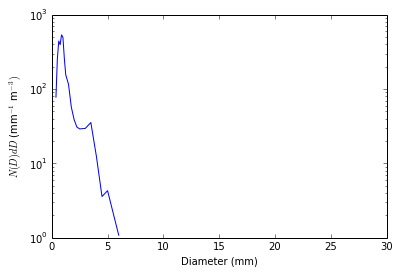

In [115]:
plt.figure()
plt.semilogy(bins_mid,dsd)
plt.xlabel('Diameter (mm)')
plt.ylabel(r'$N(D)dD$ (mm$^{-1}$ m$^{-3})$')
plt.show()

#Tarjea!

1) Write a function that will calculate the scattering parameters for S, C, and X-Band for a given size distribution.

2) Reproduce Figure 1 in Ryzhkov and Zrnic (2005). <a href="https://ams.confex.com/ams/32Rad11Meso/techprogram/paper_95684.htm">link</a>  Note that these simulations are for single particles.

3) Now, change the simulation to integrate over a Gamma particle size distribution with $N_w$=3 m$^{-4}$, $\mu$=3, standard deviation of orientation of 7$^{\circ}$ and vary $D_m$ over the range from 0.25-4.0 mm.  Does the behavior in scattering and absorption effects behave qualititatively similar to your answers in 2?

##How might we get started?
This exersise will require you to define a function in python, and iterate over values and store the model results.

Python is an indented language and this will be important in both of these issues.

Here is an example that plots the Kdp

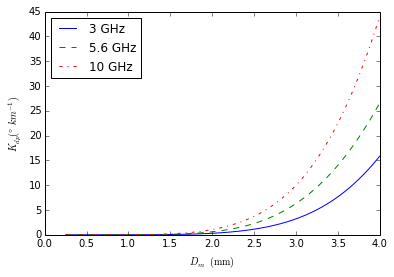

In [149]:
# initialize a scatterer object
scatterer = Scatterer()
scatterer.set_geometry(tmatrix_aux.geom_horiz_forw)

# set up orientation averaging, Gaussian PDF with mean=0 and std=7 deg
scatterer.or_pdf = orientation.gaussian_pdf(7.0)  # orientation PDF
scatterer.orient = orientation.orient_averaged_fixed  # averaging method

# set up PSD integration
scatterer.psd_integrator = psd.PSDIntegrator()
scatterer.psd_integrator.D_max = 8.0  # maximum diameter considered
scatterer.psd_integrator.geometries = (tmatrix_aux.geom_horiz_forw,)
scatterer.psd_integrator.axis_ratio_func = lambda D: 1.0/drop_ar(D)

mu=3. #constant mu
Nw=3. #m^-4
Dm = np.linspace(0.25, 4.0, 200)  # range of Dm (mm)
#lam = (4.0+mu)/Dm  # corresponding lambda parameters
W = np.pi*1e3*(Dm/4.0)**4  # corresponding water content

wavelengths = constants.c/np.array([3e9, 5.6e9, 10e9]) * 1e3  # in mm
ref_indices = [complex(8.983, 0.989), complex(8.590, 1.670),
               complex(7.718, 2.473)]
labels = ["3 GHz", "5.6 GHz", "10 GHz"]
styles = ["-", "--", "-."]


# this calculates Kdp for the given lambda parameter
def get_Kdp(Dm=None,Nw=None,mu=None,D_max=None):
    D0=((3.67+mu)/(4.+mu))*Dm
    scatterer.psd = psd.GammaPSD(D0=D0, Nw=Nw, mu=mu, D_max=D_max)  # set exponential PSD
    return radar.Kdp(scatterer)
    ###HINT ADD OTHER RADAR PARAMETERS HERE

###HINT DUPLICATE THE ABOVE TO CREATE A SCATTERING OBJECT WITH AN INDIVIDUAL PARTICLE WITH A GIVEN RADIUS

plt.figure()
for (wl, m, label, style) in zip(wavelengths, ref_indices, labels, styles):
    scatterer.wavelength = wl
    scatterer.m = m
    # initialize lookup table
    scatterer.psd_integrator.init_scatter_table(scatterer)
    Kdp = np.array([get_Kdp(Dm=idm,Nw=Nw,mu=mu,D_max=8.) for idm in Dm])
    plt.plot(Dm, 1e3*Kdp, ls=style, label=label)  # 1e3 for unit conversion to Kdp/km
plt.xlabel(r"$D_m$ $\mathrm{(mm)}$")
plt.ylabel(r"$K_{dp} (\degree \, km^{-1})$")
plt.legend(loc='best')